In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import torch
import gc
import os
import sys
%matplotlib notebook
import matplotlib.pyplot as plt

# def printmem():
#     allocated = torch.cuda.memory_allocated()
#     cached = torch.cuda.memory_cached()
#     print('Allocated:', str(allocated), '['+str(round(allocated/1000000000,3))+' GB]')
#     print('   Cached:', str(cached), '['+str(round(cached/1000000000,3))+' GB]')

module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
    
# printmem()



In [2]:
from criteria import KIDMindLoss
from helpers import Trainer
from helpers import Logger
from helpers import Trial
from mibi_dataloader import KID_Data
from modules import Mind_of_KID
import utils

# printmem()

In [3]:
# Load the data
main_dir = '/home/hazmat/Documents/projectKID/'
train_dir = main_dir + 'KID_memory/'
# test_dir = main_dir + 'low_AD/'
modl_dir = main_dir + 'models/'
rslt_dir = main_dir + 'results/'

train_ds = KID_Data(folder=train_dir, crop=55, scale=1, stride=1)
# test_ds = MIBIData(folder=test_dir, crop=32, scale=10, stride=16)

finished loading
There are  10000 samples


In [4]:
laddernet_args = dict()

# laddernet_args['batchnorm'] = False

# kidmind = Mind_of_KID()
kidmind = Mind_of_KID.load_model('/home/hazmat/Documents/projectKID/', 'model_2999')
if torch.cuda.is_available():
    kidmind.cuda()
    pass

# laddernet.cuda()
# print(owlnet)

/home/hazmat/anaconda3/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'modules.Mind_of_KID' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [5]:

kidmind_logger = Logger(['loss'])

In [6]:
kidmind_trainer = Trainer()

In [7]:
# LadderNet training parameters
kidmind_train_args = dict()
kidmind_train_args['lr'] = 0.001
kidmind_train_args['batch_size'] = 1000
kidmind_train_args['epochs'] = 1000
kidmind_train_args['report'] = 5
kidmind_train_args['crop'] = 55
kidmind_train_args['clip'] = None
kidmind_train_args['decay'] = 0
kidmind_train_args['restart'] = -1
kidmind_train_args['epoch_frac'] = 1
# laddernet_train_args['decay'] = 1e-5

# LadderNet loss parameters
kidmind_loss_args = {
    'alpha': 1, # sensory loss
    'beta': 1, # inverse loss
    'gamma': 1, # forward loss
    'delta': 1 # perceptual loss
}

train_ds.set_crop(kidmind_train_args['crop'])

In [8]:
# kidmind_train_args['continue'] = False
# kidmind.set_noise_level(0)
# kidmind_criterion = KIDMindLoss(**kidmind_loss_args)
# kidmind_trainer.train(kidmind, train_ds, kidmind_criterion, kidmind_logger, '/Users/raymondbaranski/GitHub/project_KID/models/', **kidmind_train_args)

tensor([[ 0.6057,  0.0378, -0.5185,  0.1384,  0.6315,  0.2429, -0.7348,  0.6950,
          0.9055]], device='cuda:0', grad_fn=<TanhBackward>)


<IPython.core.display.Javascript object>


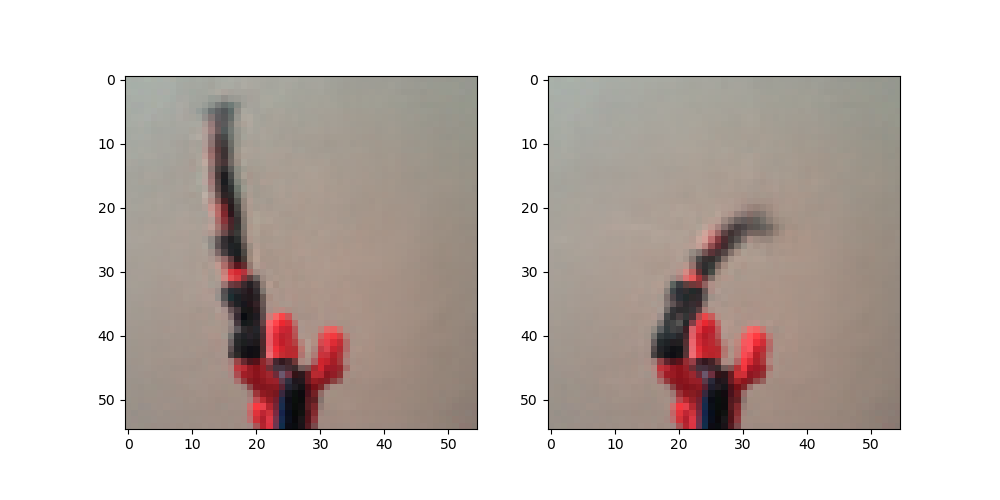

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [9]:
import numpy as np
import time
kidmind.set_noise_level(0)
kidmind.eval()

idx1 = 20
idx2 = 48

batch1 = train_ds.get_samples([idx1])
batch2 = train_ds.get_samples([idx2])

batch1 = kidmind.forward(**batch1)
batch2 = kidmind.forward(**batch2)

img1 = batch1['~s_i'][0,:,:,:].transpose(0,1).transpose(1,2).detach()
img2 = batch2['~s_i'][0,:,:,:].transpose(0,1).transpose(1,2).detach()

p = batch2['p_i']
print(p)

fig = plt.figure(figsize=[10,5])
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

ax1.imshow(img1.cpu())
ax2.imshow(img2.cpu())

In [12]:
def run_kid_run(start_state, action_sequence, model, clip_val):
    action_sequence = clip_actions(action_sequence, clip_val)
    p_states = list()
    r_states = list()
    s_states = list()
    p_states.append(start_state['p_i'])
    r_states.append(start_state['r_i'])
    s_states.append(start_state['s_i'])
    
    for i in range(len(action_sequence)):
        p_next = kidmind.forward_kinematics_model.forward(p_states[i], action_sequence[i])
        r_next = kidmind.perceptual_model.decode(p_next)
        s_next = kidmind.sensory_model.decode(r_next)
        p_states.append(p_next)
        r_states.append(r_next)
        s_states.append(s_next)
    
    return s_states, r_states, p_states

def calc_loss(target_state, state_sequence, action_sequence):
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    mse = torch.nn.MSELoss()
    target_loss = 0
    control_loss = 0
    for i in range(len(action_sequence)):
        control_loss = control_loss + mse(torch.zeros(1,3,device=device), action_sequence[i])
        # target_loss = target_loss + mse(target_state, state_sequence[-1])
    loss = target_loss + 0.1*control_loss/len(action_sequence) + 10*mse(target_state, state_sequence[-1])
    return loss

def clip_actions(actions, clip_val):
    for i in range(len(actions)):
        action = actions[i]
        r = torch.norm(action).detach()
        if r > clip_val:
            action = action / r * clip_val
            actions[i] = action
    return actions

def gen_actions(**kwargs):
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    if 'N' in kwargs:
        N = kwargs['N']
        actions = list()
        for i in range(N):
            action = torch.randn(1, 3, requires_grad=True, device=device)
            actions.append(action)
    elif 'actions' in kwargs:
        parent = kwargs['actions']
        actions = list()
        noise_lvl = kwargs['noise_lvl']
        for i in range(len(parent)):
            action = parent[i] + torch.randn(1, 3, requires_grad=True, device=device) * noise_lvl
            action = torch.tensor(action)
            actions.append(action)
    return actions

def calc_fitness(population, start_state, target_state, model, clip_val):
    fitness = np.zeros(len(population))
    for i in range(len(population)):
        action_sequence = population[i]
        s_states, r_states, p_states = run_kid_run(start_state, action_sequence, model, clip_val)
        state_sequence = r_states
        fitness[i] = calc_loss(target_state['r_i'], state_sequence, action_sequence)
    return fitness

def seed_population(N, pop_size):
    population = list()
    for i in range(pop_size):
        population.append(gen_actions(N=N))
    return population

def optimize_seq(actions, start, target, model, steps, learning_rate, clip_val):
    for i in range(len(actions)):
        actions[i] = torch.tensor(actions[i])
    optimizer = torch.optim.Adam(actions, lr=learning_rate)
    for i in range(steps):
        optimizer.zero_grad()
        model.zero_grad()
        s_states, r_states, p_states = run_kid_run(start, actions, model, clip_val)
        loss = calc_loss(target['r_i'], r_states, actions)
        loss.backward(retain_graph=True)
        optimizer.step()
        # print(i, loss, end='\r')
    for i in range(len(actions)):
        actions[i] = torch.tensor(actions[i])
    return actions

def optimize_pop(population, start, target, model, steps, learning_rate, clip_val):
    for i in range(len(population)):
        population[i] = optimize_seq(population[i], start, target, model, steps, learning_rate, clip_val)
    return population

def select_sequences(population, fitness, n_cut, n_children, noise_lvl):
    # print(np.min(fitness))
    indices = np.argsort(fitness)
    s_population = list()
    s_fitness = list()
    for i in range(len(indices)):
        s_population.append(population[indices[i]])
        s_fitness.append(fitness[indices[i]])
    s_population = s_population[0:n_cut]
    s_fitness = s_fitness[0:n_cut]
    population = s_population
    for i in range(len(s_population)):
        for j in range(n_children):
            population.append(gen_actions(actions=s_population[i], noise_lvl=noise_lvl))
    return population

def evolve(population, start, target, model, clip_val, genetic_args):
    if genetic_args['optimize']:
        steps = genetic_args['steps']
        learning_rate = genetic_args['learning_rate']
        population = optimize_pop(population, start, target, model, steps, learning_rate, clip_val)
    fitness = calc_fitness(population, start, target, model, clip_val)
    n_cut = genetic_args['n_cut']
    n_children = genetic_args['n_children']
    noise_lvl = genetic_args['noise_lvl']
    population = select_sequences(population, fitness, n_cut, n_children, noise_lvl)
    return population

def get_sequence(start, target, model, clip_val, genetic_args):
    population = seed_population(genetic_args['seq_length'], genetic_args['pop_size'])
    for i in range(genetic_args['generations']):
        population = evolve(population, start, target, model, clip_val, genetic_args)
    actions = population[0]
    s_states, r_states, p_states = run_kid_run(start, actions, model, clip_val)
    return s_states, r_states, p_states

def gen_rand_seq(dataset, model, clip_val, genetic_args):
    import numpy as np
    start_idx = np.random.choice(int(dataset.num_points)-2)+1
    target_idx = np.random.choice(int(dataset.num_points)-2)+1
    start = dataset.get_samples([start_idx])
    target = dataset.get_samples([target_idx])
    start = model.forward(**start)
    target = model.forward(**target)
    s_states, r_states, p_states = get_sequence(start, target, model, clip_val, genetic_args)
    return s_states, r_states, p_states, target

def build_dataset(num_seqs, dataset, model, clip_val, genetic_args):
    import time
    r_target = list()
    p_t = list()
    p_next = list()
    for i in range(num_seqs):
        t = time.time()
        s_states, r_states, p_states, target = gen_rand_seq(dataset, model, clip_val, genetic_args)
        for j in range(len(s_states)-1):
            r_target.append(torch.tensor(target['r_i']).cpu())
            p_t.append(torch.tensor(p_states[j]).cpu())
            p_next.append(torch.tensor(p_states[j+1]).cpu())
        print(i, time.time() - t, ' seconds')
    return r_target, p_t, p_next

In [13]:
genetic_args = dict()
genetic_args['pop_size'] = 100
genetic_args['seq_length'] = 3
genetic_args['generations'] = 25
genetic_args['steps'] = 1
genetic_args['learning_rate'] = 1
genetic_args['n_cut'] = 10
genetic_args['n_children'] = 9
genetic_args['noise_lvl'] = 0.2
genetic_args['optimize'] = True

clip_val = 0.5


In [ ]:
num_seqs = 10000
import time
t = time.time()
r_target, p_t, p_next = build_dataset(num_seqs, train_ds, kidmind, clip_val, genetic_args)
time_passed = time.time() - t
print(time_passed, ' seconds')
print(time_passed / 60 / 60 / 24, ' hours')

/home/hazmat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/hazmat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/hazmat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/hazmat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

0 61.17596745491028  seconds
1 56.46227812767029  seconds
2 54.598387002944946  seconds
3 53.87715435028076  seconds
4 57.142887115478516  seconds
5 56.754841327667236  seconds
6 55.767205476760864  seconds
7 56.357850790023804  seconds
8 56.09167456626892  seconds
9 55.952311277389526  seconds
10 55.339420557022095  seconds
11 56.04512095451355  seconds
12 56.510703325271606  seconds
13 57.198683977127075  seconds
14 56.265124559402466  seconds
15 54.67307686805725  seconds
16 52.294827699661255  seconds
17 51.98737859725952  seconds
18 52.3304648399353  seconds
19 52.19501090049744  seconds
20 52.38696360588074  seconds
21 52.23537230491638  seconds
22 52.24742579460144  seconds
23 52.128878116607666  seconds
24 52.43152856826782  seconds
25 52.5643789768219  seconds
26 52.270508766174316  seconds
27 52.30493712425232  seconds
28 52.59807777404785  seconds
29 52.30650854110718  seconds
30 52.47958254814148  seconds
31 53.60077428817749  seconds
32 56.14865517616272  seconds
33 56.412

266 55.423566579818726  seconds
267 56.43513631820679  seconds
268 54.84678411483765  seconds
269 55.44061636924744  seconds
270 54.46920323371887  seconds
271 56.311057567596436  seconds
272 51.6846284866333  seconds
273 50.13612627983093  seconds
274 50.240031480789185  seconds
275 50.21374273300171  seconds
276 50.11287045478821  seconds
277 50.370877504348755  seconds
278 50.22129487991333  seconds
279 50.19351148605347  seconds
280 50.283008337020874  seconds
281 50.02511954307556  seconds
282 50.048630714416504  seconds
283 50.06889295578003  seconds
284 50.09194016456604  seconds
285 50.309362173080444  seconds
286 50.05703854560852  seconds
287 51.39146947860718  seconds
288 50.10497307777405  seconds
289 50.19896578788757  seconds
290 50.02288317680359  seconds
291 49.80583357810974  seconds
292 50.28186082839966  seconds
293 50.453049421310425  seconds
294 49.73127841949463  seconds
295 49.99203944206238  seconds
296 50.11282205581665  seconds
297 49.51379203796387  seconds
2

529 53.95894479751587  seconds
530 54.01370930671692  seconds
531 54.47291421890259  seconds
532 54.11573553085327  seconds
533 53.65026926994324  seconds
534 52.412944078445435  seconds
535 51.86179280281067  seconds
536 54.2692711353302  seconds
537 54.39968490600586  seconds
538 53.668865442276  seconds
539 53.182583808898926  seconds
540 53.18605184555054  seconds
541 51.9774751663208  seconds
542 51.84351348876953  seconds
543 53.91333293914795  seconds
544 55.746870279312134  seconds
545 54.94411778450012  seconds
546 54.80072283744812  seconds
547 54.17655396461487  seconds
548 52.6888964176178  seconds
549 53.498377084732056  seconds
550 54.9605073928833  seconds
551 52.40951633453369  seconds
552 52.4395649433136  seconds
553 53.405925273895264  seconds
554 53.11055111885071  seconds
555 51.62238430976868  seconds
556 51.859973669052124  seconds
557 53.40918684005737  seconds
558 54.62452006340027  seconds
559 53.89992022514343  seconds
560 54.736998558044434  seconds
561 54.3

792 54.669114112854004  seconds
793 54.6279935836792  seconds
794 54.870113372802734  seconds
795 54.86778235435486  seconds
796 51.149359464645386  seconds
797 52.988736391067505  seconds
798 52.176642656326294  seconds
799 52.11651086807251  seconds
800 53.708492279052734  seconds
801 52.93466329574585  seconds
802 53.987202882766724  seconds
803 52.479819774627686  seconds
804 53.28482389450073  seconds
805 52.192384243011475  seconds
806 52.48315954208374  seconds
807 51.94611668586731  seconds
808 55.438331842422485  seconds
809 55.69258093833923  seconds
810 55.013510942459106  seconds
811 49.43438959121704  seconds
812 48.916767597198486  seconds
813 50.089709520339966  seconds
814 49.20925760269165  seconds
815 49.24197840690613  seconds
816 49.14724922180176  seconds
817 49.145195960998535  seconds
818 49.30815577507019  seconds
819 49.13170599937439  seconds
820 49.29295349121094  seconds
821 49.13480257987976  seconds
822 48.72625017166138  seconds
823 49.20497393608093  sec

1053 55.374385595321655  seconds
1054 55.332234382629395  seconds
1055 53.35533428192139  seconds
1056 53.36590814590454  seconds
1057 52.162243127822876  seconds
1058 53.35084056854248  seconds
1059 55.486751079559326  seconds
1060 54.935001850128174  seconds
1061 54.915828704833984  seconds
1062 54.17954921722412  seconds
1063 55.226529598236084  seconds
1064 55.68160796165466  seconds
1065 56.02197027206421  seconds
1066 56.99217224121094  seconds
1067 54.36279368400574  seconds
1068 55.29879641532898  seconds
1069 55.02744245529175  seconds
1070 55.04258966445923  seconds
1071 56.47413206100464  seconds
1072 56.159334659576416  seconds
1073 55.82667922973633  seconds
1074 56.418172121047974  seconds
1075 53.577228307724  seconds
1076 54.039710521698  seconds
1077 53.77105236053467  seconds
1078 54.81652355194092  seconds
1079 54.446775674819946  seconds
1080 52.81314206123352  seconds
1081 54.730396032333374  seconds
1082 52.77609610557556  seconds
1083 49.49912476539612  seconds
1

1308 55.424705028533936  seconds
1309 54.33665704727173  seconds
1310 50.855252742767334  seconds
1311 50.767080545425415  seconds
1312 50.757017612457275  seconds
1313 50.6917245388031  seconds
1314 53.063233613967896  seconds
1315 54.20362114906311  seconds
1316 54.94841933250427  seconds
1317 56.21777296066284  seconds
1318 55.93904995918274  seconds
1319 54.808908224105835  seconds
1320 54.719396352767944  seconds
1321 55.49188256263733  seconds
1322 55.948365211486816  seconds
1323 55.77082586288452  seconds
1324 55.3585307598114  seconds
1325 55.36902976036072  seconds
1326 54.38556790351868  seconds
1327 51.986931800842285  seconds
1328 52.59915733337402  seconds
1329 54.16974186897278  seconds
1330 54.17364048957825  seconds
1331 53.09170579910278  seconds
1332 53.07484221458435  seconds
1333 52.86658191680908  seconds
1334 49.14440584182739  seconds
1335 49.25579261779785  seconds
1336 49.003989458084106  seconds
1337 49.03491187095642  seconds
1338 54.084450006484985  seconds

1563 55.09890627861023  seconds
1564 55.208500385284424  seconds
1565 54.592907667160034  seconds
1566 54.23907136917114  seconds
1567 54.48566389083862  seconds
1568 54.69508457183838  seconds
1569 56.23827624320984  seconds
1570 52.142486333847046  seconds
1571 51.97608923912048  seconds
1572 51.847455739974976  seconds
1573 53.08850383758545  seconds
1574 55.30891299247742  seconds
1575 56.702723264694214  seconds
1576 55.70313835144043  seconds
1577 56.85270833969116  seconds
1578 55.57799673080444  seconds
1579 55.56485342979431  seconds
1580 55.66187834739685  seconds
1581 55.52696752548218  seconds
1582 55.58389902114868  seconds
1583 54.27815794944763  seconds
1584 55.14528250694275  seconds
1585 56.21053409576416  seconds
1586 56.35040235519409  seconds
1587 54.53506326675415  seconds
1588 54.052042722702026  seconds
1589 53.08080816268921  seconds
1590 52.75063371658325  seconds
1591 54.61357927322388  seconds
1592 54.16213583946228  seconds
1593 53.41817092895508  seconds
15

1818 50.731452226638794  seconds
1819 51.37027192115784  seconds
1820 51.31702637672424  seconds
1821 51.404518365859985  seconds
1822 51.18552112579346  seconds
1823 51.96338725090027  seconds
1824 53.57226300239563  seconds
1825 54.06484818458557  seconds
1826 53.5266010761261  seconds
1827 52.97401189804077  seconds
1828 53.07010746002197  seconds
1829 52.9904682636261  seconds
1830 53.26255393028259  seconds
1831 53.16146755218506  seconds
1832 55.26573371887207  seconds
1833 52.37902498245239  seconds
1834 53.14523124694824  seconds
1835 53.32712006568909  seconds
1836 54.40492224693298  seconds
1837 54.09747838973999  seconds
1838 51.08453345298767  seconds
1839 49.66645574569702  seconds
1840 49.45550560951233  seconds
1841 54.72554588317871  seconds
1842 56.03055500984192  seconds
1843 52.58602786064148  seconds
1844 52.541017293930054  seconds
1845 56.412177085876465  seconds
1846 56.893643379211426  seconds
1847 55.18594455718994  seconds
1848 54.8840868473053  seconds
1849 5

2073 55.20774960517883  seconds
2074 54.504706382751465  seconds
2075 54.65251064300537  seconds
2076 53.92042326927185  seconds
2077 55.685996770858765  seconds
2078 54.94350600242615  seconds
2079 54.94410800933838  seconds
2080 52.9918417930603  seconds
2081 53.08290100097656  seconds
2082 51.96221351623535  seconds
2083 49.46154546737671  seconds
2084 49.37829065322876  seconds
2085 49.42299699783325  seconds
2086 52.224669456481934  seconds
2087 53.23884105682373  seconds
2088 53.806843280792236  seconds
2089 53.24635887145996  seconds
2090 53.22764754295349  seconds
2091 53.439098596572876  seconds
2092 54.70445656776428  seconds
2093 53.674301624298096  seconds
2094 56.71911263465881  seconds
2095 53.760427713394165  seconds
2096 52.409385681152344  seconds
2097 51.87377715110779  seconds
2098 52.028361558914185  seconds
2099 51.91163110733032  seconds
2100 51.8835506439209  seconds
2101 51.50126647949219  seconds
2102 51.99417853355408  seconds
2103 51.760446310043335  seconds


2327 56.13752317428589  seconds
2328 56.33202409744263  seconds
2329 55.016133546829224  seconds
2330 55.00729417800903  seconds
2331 54.894949436187744  seconds
2332 52.408836126327515  seconds
2333 50.557496786117554  seconds
2334 50.73205018043518  seconds
2335 50.89109826087952  seconds
2336 50.57697105407715  seconds
2337 54.84705066680908  seconds
2338 56.74533772468567  seconds
2339 54.70968580245972  seconds
2340 55.36171555519104  seconds
2341 55.38800835609436  seconds
2342 54.631964683532715  seconds
2343 54.91374206542969  seconds
2344 54.99831247329712  seconds
2345 55.99220275878906  seconds
2346 55.11802792549133  seconds
2347 54.06122541427612  seconds
2348 55.16484498977661  seconds
2349 53.736774921417236  seconds
2350 50.96745252609253  seconds
2351 50.93732237815857  seconds
2352 51.22920870780945  seconds
2353 51.999229192733765  seconds
2354 53.780757188797  seconds
2355 56.21382975578308  seconds
2356 55.52278709411621  seconds
2357 51.772132396698  seconds
2358 

2582 55.623671770095825  seconds
2583 54.87779784202576  seconds
2584 52.45385456085205  seconds
2585 54.62121915817261  seconds
2586 53.078999757766724  seconds
2587 54.67775583267212  seconds
2588 54.751341581344604  seconds
2589 53.89304256439209  seconds
2590 55.25214910507202  seconds
2591 55.85669779777527  seconds
2592 54.46504545211792  seconds
2593 56.193044662475586  seconds
2594 55.454771280288696  seconds
2595 56.142279386520386  seconds
2596 56.287009716033936  seconds
2597 54.49485778808594  seconds
2598 54.53782796859741  seconds
2599 54.98971748352051  seconds
2600 55.60835075378418  seconds
2601 51.699047803878784  seconds
2602 51.69442439079285  seconds
2603 51.564314126968384  seconds
2604 56.02095603942871  seconds
2605 56.92903447151184  seconds
2606 55.4224169254303  seconds
2607 54.024324893951416  seconds
2608 53.6140673160553  seconds
2609 52.61370658874512  seconds
2610 53.663328886032104  seconds
2611 53.705660820007324  seconds
2612 52.87151741981506  second

2837 54.358699321746826  seconds
2838 53.995049715042114  seconds
2839 53.77679753303528  seconds
2840 54.1111855506897  seconds
2841 53.67628765106201  seconds
2842 52.33099389076233  seconds
2843 52.856831550598145  seconds
2844 53.734095335006714  seconds
2845 52.27660417556763  seconds
2846 52.44292593002319  seconds
2847 52.70795273780823  seconds
2848 54.610437631607056  seconds
2849 54.462029695510864  seconds
2850 54.43526577949524  seconds
2851 56.014304876327515  seconds
2852 54.548375844955444  seconds
2853 54.661750078201294  seconds
2854 54.739373207092285  seconds
2855 54.271400928497314  seconds
2856 53.75613188743591  seconds
2857 54.81223177909851  seconds
2858 54.22671175003052  seconds
2859 55.71671390533447  seconds
2860 55.511849880218506  seconds
2861 54.61124801635742  seconds
2862 54.95496106147766  seconds
2863 55.584755420684814  seconds
2864 53.68368625640869  seconds
2865 53.82892894744873  seconds
2866 55.533828020095825  seconds
2867 55.632076025009155  se

3091 51.31752300262451  seconds
3092 51.44685697555542  seconds
3093 51.299221992492676  seconds
3094 51.721434593200684  seconds
3095 56.35698914527893  seconds
3096 53.32301068305969  seconds
3097 52.62352681159973  seconds
3098 52.91725945472717  seconds
3099 55.1098415851593  seconds
3100 55.65489959716797  seconds
3101 54.87484407424927  seconds
3102 56.87562108039856  seconds
3103 56.42960786819458  seconds
3104 56.80164670944214  seconds
3105 56.43536567687988  seconds
3106 55.097530126571655  seconds
3107 55.47766971588135  seconds
3108 56.66884708404541  seconds
3109 54.793832302093506  seconds
3110 52.46267342567444  seconds
3111 49.909855365753174  seconds
3112 49.11662936210632  seconds
3113 49.14255499839783  seconds
3114 49.165058851242065  seconds
3115 49.16540193557739  seconds
3116 49.1951117515564  seconds
3117 49.27218818664551  seconds
3118 49.16196846961975  seconds
3119 49.07428026199341  seconds
3120 54.99559140205383  seconds
3121 54.0962393283844  seconds
3122 

3345 49.639639139175415  seconds
3346 52.87947750091553  seconds
3347 54.56504201889038  seconds
3348 53.75286674499512  seconds
3349 53.80468726158142  seconds
3350 52.84823799133301  seconds
3351 53.30022692680359  seconds
3352 51.23508071899414  seconds
3353 49.66221594810486  seconds
3354 49.21351170539856  seconds
3355 49.48029971122742  seconds
3356 49.4761643409729  seconds
3357 49.6477997303009  seconds
3358 49.410821199417114  seconds
3359 49.535239934921265  seconds
3360 49.531453132629395  seconds
3361 49.51789975166321  seconds
3362 49.11866092681885  seconds
3363 49.33111381530762  seconds
3364 49.377262115478516  seconds
3365 49.457051038742065  seconds
3366 53.06551384925842  seconds
3367 55.01218271255493  seconds
3368 55.542598724365234  seconds
3369 51.50334906578064  seconds
3370 49.32121205329895  seconds
3371 49.31340146064758  seconds
3372 49.52065992355347  seconds
3373 49.64236235618591  seconds
3374 49.37154483795166  seconds
3375 49.36728525161743  seconds
337

3599 51.63889813423157  seconds
3600 51.83266592025757  seconds
3601 51.760592460632324  seconds
3602 52.03441095352173  seconds
3603 51.97472834587097  seconds
3604 51.65427923202515  seconds
3605 52.00374674797058  seconds
3606 51.936689376831055  seconds
3607 52.110106468200684  seconds
3608 51.75825762748718  seconds
3609 51.91102433204651  seconds
3610 52.87628483772278  seconds
3611 55.134822368621826  seconds
3612 53.93075728416443  seconds
3613 54.94802784919739  seconds
3614 55.61864113807678  seconds
3615 56.424158573150635  seconds
3616 56.12952756881714  seconds
3617 55.836779832839966  seconds
3618 56.31998801231384  seconds
3619 57.068156242370605  seconds
3620 55.518088579177856  seconds
3621 54.6253342628479  seconds
3622 51.039085149765015  seconds
3623 49.47172236442566  seconds
3624 49.60209679603577  seconds
3625 49.292484521865845  seconds
3626 49.37945556640625  seconds
3627 49.15723395347595  seconds
3628 49.587992906570435  seconds
3629 49.74721908569336  second

3854 55.44525122642517  seconds
3855 53.07009267807007  seconds
3856 56.39269137382507  seconds
3857 53.30211114883423  seconds
3858 53.1278977394104  seconds
3859 56.17630076408386  seconds
3860 56.32928943634033  seconds
3861 54.416011571884155  seconds
3862 53.96530294418335  seconds
3863 55.042558431625366  seconds
3864 54.05842661857605  seconds
3865 53.29894781112671  seconds
3866 54.85292887687683  seconds
3867 55.14831209182739  seconds
3868 54.791754484176636  seconds
3869 55.470985412597656  seconds
3870 55.433857679367065  seconds
3871 55.272186040878296  seconds
3872 56.06640410423279  seconds
3873 54.20343565940857  seconds
3874 55.67966151237488  seconds
3875 55.16402983665466  seconds
3876 53.36822247505188  seconds
3877 53.79117488861084  seconds
3878 54.02292275428772  seconds
3879 54.0887176990509  seconds
3880 54.53520727157593  seconds
3881 55.32859802246094  seconds
3882 56.27579116821289  seconds
3883 51.60090231895447  seconds
3884 49.02298879623413  seconds
3885

In [ ]:
raw_seq_data = dict()
raw_seq_data['r_target'] = r_target
raw_seq_data['p_t'] = p_t
raw_seq_data['p_next'] = p_next

import pickle
pickle.dump(raw_seq_data, open(main_dir + 'raw_seq_data.p', 'wb'))

In [91]:
# raw_seq_data = []
# print(raw_seq_data)
# raw_seq_data = pickle.load(open(main_dir + 'raw_seq_data.p', 'rb'))
# print(raw_seq_data)

[]
{'r_target': [tensor([[ 0.6113,  0.6431, -0.6661]]), tensor([[ 0.6113,  0.6431, -0.6661]]), tensor([[ 0.6113,  0.6431, -0.6661]])], 'p_t': [tensor([[ 0.8511, -0.0852,  0.1823,  0.9223,  0.1661, -0.1896, -0.5744,  0.5858,
          0.6917]]), tensor([[ 0.5037, -0.1267,  0.3646, -0.1162,  0.6954,  0.0765, -0.7305,  0.6788,
          0.5773]]), tensor([[ 0.5086, -0.1642,  0.3507, -0.0731,  0.6959,  0.0434, -0.7403,  0.6879,
          0.6082]])], 'p_next': [tensor([[ 0.5037, -0.1267,  0.3646, -0.1162,  0.6954,  0.0765, -0.7305,  0.6788,
          0.5773]]), tensor([[ 0.5086, -0.1642,  0.3507, -0.0731,  0.6959,  0.0434, -0.7403,  0.6879,
          0.6082]]), tensor([[ 0.4981, -0.0221,  0.1885, -0.2434,  0.7206,  0.1720, -0.7502,  0.6924,
          0.6887]])]}


In [70]:
# start_batch = train_ds.get_samples([idx1])
# target_batch = train_ds.get_samples([idx2])

# start = kidmind.forward(**start_batch)
# target = kidmind.forward(**target_batch)

In [71]:
# s_states, r_states, p_states = get_sequence(start, target, kidmind, clip_val, genetic_args)

In [72]:
# population = seed_population(N=3, pop_size=100)
# steps = 1
# learning_rate = 1
# n_cut = 10
# n_children = 9
# noise_lvl = 0.2
# clip_val = 0.5
# optimize = True

# generations = 25
# for i in range(generations):
#     population = evolve(population, start, target, kidmind, steps, learning_rate, n_cut, n_children, noise_lvl, clip_val, optimize)

# s_states, r_states, p_states = gen_rand_seq(train_ds, kidmind, clip_val, genetic_args)

/home/hazmat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/hazmat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/hazmat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


<IPython.core.display.Javascript object>


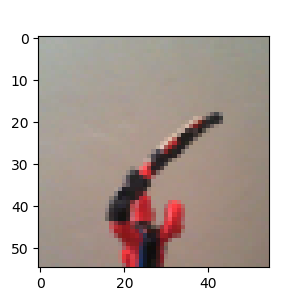

<IPython.core.display.Javascript object>


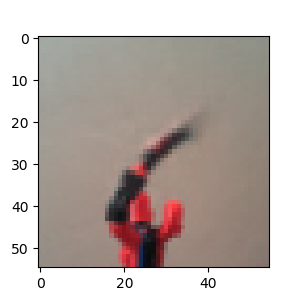

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<IPython.core.display.Javascript object>


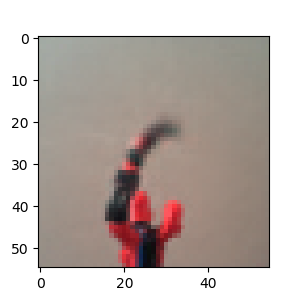

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<IPython.core.display.Javascript object>


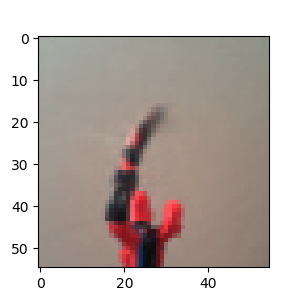

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [67]:
import skimage.io as io

# actions = population[0]
# s_states, r_states, p_states = run_kid_run(start, actions, kidmind, clip_val)
for i in range(len(s_states)):
    fig = plt.figure(figsize=[3,3])
    img = s_states[i][0,:,:,:].transpose(0,1).transpose(1,2).detach().cpu()
    img[img>1] = 1
    img[img<0] = 0
    # io.imsave('/Users/raymondbaranski/Desktop/imgs/' + str(i) + '.png', img)
    plt.imshow(s_states[i][0,:,:,:].transpose(0,1).transpose(1,2).detach().cpu())

In [ ]:
# from mpl_toolkits.mplot3d import Axes3D

# import matplotlib.pyplot as plt
# import numpy as np

# fig = plt.figure(figsize=[10,10])
# ax = fig.add_subplot(1, 1, 1, projection='3d')
# ax.scatter(x[:,0], x[:,1], x[:,2], '.')

In [ ]:
actions

In [ ]:
print(p_states[0])
print(actions[0])
p_next = kidmind.forward_kinematics_model.forward(p_states[0], actions[0])
print('')
print(p_next)
print(p_states[1])
print('')
print(target['r_i'])
print(r_states[-1])

In [ ]:
r_states[1]

In [ ]:
p_states[2]

In [ ]:
print('start: ', p_states[0])
print('action:', actions[0])
p_next = kidmind.forward_kinematics_model.forward(p_states[0], actions[0])
print('')
print(p_next)
for i in range(len(p_states)):
    print(p_states[i])

In [ ]:
import numpy as np
batch = train_ds.get_samples(np.random.permutation(1000))
s_states = batch['s_i']
r_states, pre_r_states = kidmind.sensory_model.encode(s_states)

In [ ]:
data = pre_r_states[:,0].cpu().detach().numpy()
# print(data)
hist = np.histogram(data)

In [ ]:
torch.mean(r_states,0)

In [ ]:
torch.std(r_states,0)

In [ ]:
torch.sqrt(kidmind.sensory_model.bn8.running_var)

In [ ]:
fig = plt.figure()
plt.hist(data, bins=1000)
print(torch.std(torch.tensor(data)))